# Practica 1
---
Author: Antoni Payeras, Andreu Sureda <br>
Date: data
---

##### 1. AUX FUNCTIONS

In [138]:
def plot_confusion_matrix(y_test, y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, classification_report

    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict = True)

    accuracy = report['accuracy']
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    macro_avg = report['macro avg']
    weight_avg = report['weighted avg']
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}\nMacro Avg Metrics\nprecision={:0.4f} recall={:0.4f} f1={:0.4f}\nWeighted Avg Metrics\nprecision={:0.4f} recall={:0.4f} f1={:0.4f}'.format(accuracy, misclass,macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], weight_avg['precision'], weight_avg['recall'], weight_avg['f1-score']))
    plt.show()

## Les dades

In [139]:
import pandas as pd

df = pd.read_csv("data.csv", delimiter=r"\s+")
df = df.drop(['0'], axis=1)

In [140]:
df.head()

,catala,angles
0,com,as
1,seva,his
2,que,that
3,ell,he
4,era,was


Primer afegirem la variable de lang a cada un dels idiomes, per poder diferenciar l'idioma de cada paraula

In [141]:
df_cat = df[["catala"]]
df_cat['lang'] = 0
df_cat = df_cat.rename(columns={'catala': 'paraula'})


df_ang = df[["angles"]]
df_ang['lang'] = 1
df_ang = df_ang.rename(columns={'angles': 'paraula'})

Unió dels diferents dataframes de cada llenguatge 

In [142]:
df_final = pd.concat([df_cat, df_ang], ignore_index=True, sort=False)
df_final.shape

(1976, 2)

### Neteja de les dades
#### 1. Eliminació de caracters especials

In [143]:
df_final['paraula'] = df_final['paraula'].str.replace("[\\:.,;_*+^\[\]\(\)/&€%$~\"ªº?¿¡!0-9]", "", regex=True)

df_final = df_final[df_final['paraula'] != '']

#### 2. Passar a mínuscula tot

In [144]:
df_final['paraula'] = df_final['paraula'].str.lower()

#### 3. Eliminació de paraules repetides en el mateix idoma.

La aparició d'una mateixa paraula a un mateix idioma, podria ocasionarmos problemes, ja que podriem estar sobreentrenant per a aquella paraula en concret ?????

In [145]:
df_final = df_final.drop_duplicates(subset=['paraula','lang'])
df_final.shape

(1845, 2)

#### 4. Eliminació de paraules repetides en diferents idomes.

In [146]:
df_final = df_final.drop_duplicates(subset=['paraula'], keep=False)	
print(df_final.shape)

print(df_final[df_final['lang'] == 1].shape)
print(df_final[df_final['lang'] == 0].shape)

(1723, 2)
(926, 2)
(797, 2)


## Definició de característiques

* Conté accents
* Conté la lletra "y"
* Conté la lletra "w"
* Conté el diagraf "sh"
* Conté el diagraf "ph"
* Conté la lletra "ç"
* Conté el digraf "l·l"

In [149]:

import re
from Levenshtein import distance as lev

import wordfreq
catalan_common_words = wordfreq.top_n_list('ca', 10000)
english_common_words = wordfreq.top_n_list('en', 10000)

features_columns = ['has_accent','has_y','has_w','has_sh','has_ph','has_ç','has_ll','has_u', 'cat_prefix', 'eng_prefix', 
                    'cat_suffix', 'eng_suffix', 'dist_levenshtein_ca','dist_levenshtein_en']
#'eng_freq', 'cat_freq']

cat_prefixes = ['ab', 'amfi', 'ana', 'ante', 'apo', 'avant', 'arxi', 'ben', 'bes', 'bes', 'bi', 'circum', 'cat', 'contra', 'des', 'di', 'endo', 'eso', 'ex', 'eu', 'hemi', 'hiper', 'hipo', 'fora', 'infra', 'intro', 'macro', 'mal', 'met', 'micro', 'menys', 'mono', 'multi', 'neo', 'pan', 'par', 'pen', 'per', 'peri', 'pluri', 'poli', 'prop', 'proto', 'pseudo', 'quasi', 'retro', 'sin', 'sota', 'supra', 'sus', 'uni', 'vice']
cat_suffixes = ['ana', 'aca', 'ada', 'àlgia', 'aire', 'all', 'alla', 'am', 'ar', 'ari', 'ària', 'as', 'assa', 'assar', 'at', 'at', 'ada', 'atge', 'ble', 'ea', 'ció', 'dís', 'dor', 'dora', 'eda', 'et', 'egar', 'ejar', 'enc', 'enc', 'enca', 'era', 'eria', 'esa', 'et', 'ia', 'ícia', 'ificar', 'il', 'im', 'ís', 'issa', 'isme', 'ista', 'iste', 'ista', 'ístic', 'itar', 'itzar', 'ívol', 'ívola', 'menta', 'nça', 'ó', 'òria', 'ós', 'osa', 'osa', 'um', 'úria', 'ura', 'ut', 'uda']
eng_prefixes = ['down', 'hyper', 'il', 'im', 'ir', 'inter', 'mega', 'mid', 'mis', 'non', 'over', 'out', 'post', 'pre', 'semi', 'sub', 'super', 'trans', 'ultra', 'un', 'under', 'up', 'a', 'after', 'back', 'be', 'by', 'en', 'em', 'fore', 'hind', 'midi', 'mini', 'off', 'self', 'step', 'twi', 'under', 'with']
eng_suffixes = ['age', 'al', 'ance', 'ence', 'dom', 'ee', 'er', 'or', 'hood', 'ism', 'ist', 'ity', 'ty', 'ment', 'ness', 'ry', 'ship', 'sion', 'tion', 'xion', 'able', 'ible', 'al', 'ese', 'ful', 'ic', 'ish', 'ive', 'ian', 'less', 'ly', 'ous', 'y', 'ate', 'en', 'ify', 'ise', 'ize', 'ly', 'ward', 'wards', 'wise']


def starts_with_prefix(word, prefixes):
    for prefix in prefixes:
        if word.startswith(prefix):
            return 1
    return 0


def ends_with_suffix(word, suffixes):
    for suffix in suffixes:
        if word.endswith(suffix):
            return 1
    return 0

## ü


def get_levenshtein_lang(word, lang) : 

    df_words = df_final[df_final['lang'] == lang]
    words = df_words['paraula'].tolist()
    
    # Eliminar paraula de llista
    if word in words:
        index = words.index(word)
        words.pop(index)

    # Calculate the Levenshtein distances for each row
    distances = [lev(word, _word) for _word in words]
    return min(distances)


def _features(word) :
    has_accent =  1 if re.search("[àèìòùáéíóú]", word, re.IGNORECASE) else 0
    has_y = 1 if re.search("y", word, re.IGNORECASE) else 0
    has_w = 1 if re.search("w", word, re.IGNORECASE) else 0
    has_sh = 1 if re.search("sh", word, re.IGNORECASE) else 0
    has_ph = 1 if re.search("ph", word, re.IGNORECASE) else 0
    has_ç = 1 if re.search("ç", word, re.IGNORECASE) else 0
    has_ll = 1 if re.search("l·l", word, re.IGNORECASE) else 0
    has_u = 1 if re.search("ü", word, re.IGNORECASE) else 0
    cat_prefix = starts_with_prefix(word, cat_prefixes)
    eng_prefix = starts_with_prefix(word, eng_prefixes)
    cat_suffix = ends_with_suffix(word, cat_suffixes)
    eng_suffix = ends_with_suffix(word, eng_suffixes)
    dist_levenshtein_ca = get_levenshtein_lang(word, 0)
    dist_levenshtein_en = get_levenshtein_lang(word, 1)
    #eng_freq = 1 if word in english_common_words else 0
    #cat_freq = 1 if word in catalan_common_words else 0
    return [has_accent,has_y,has_w,has_sh,has_ph,has_ç,has_ll, has_u, cat_prefix, eng_prefix, 
            cat_suffix, eng_suffix, dist_levenshtein_ca, dist_levenshtein_en#, eng_freq, cat_freq
    ]


features = df_final.apply(lambda row: _features(row['paraula']), axis = 1, )
df_1 = pd.DataFrame.copy(df_final)
df_1[features_columns] = features.tolist()
df_1

,paraula,lang,has_accent,has_y,has_w,has_sh,has_ph,has_ç,has_ll,has_u,cat_prefix,eng_prefix,cat_suffix,eng_suffix,dist_levenshtein_ca,dist_levenshtein_en
0,com,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,seva,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,que,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
3,ell,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,era,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,prepare,1,0,0,0,0,0,0,0,0,0,1,0,0,2,3
1970,salt,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2
1971,nose,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1
1973,anger,1,0,0,0,0,0,0,0,0,0,1,0,1,2,1


### Comprovació de validesa de les característiques escollidess

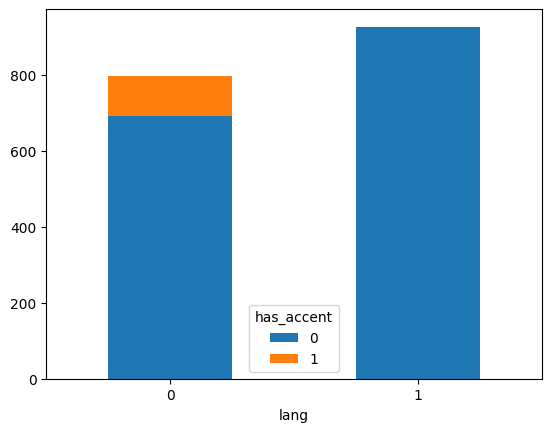

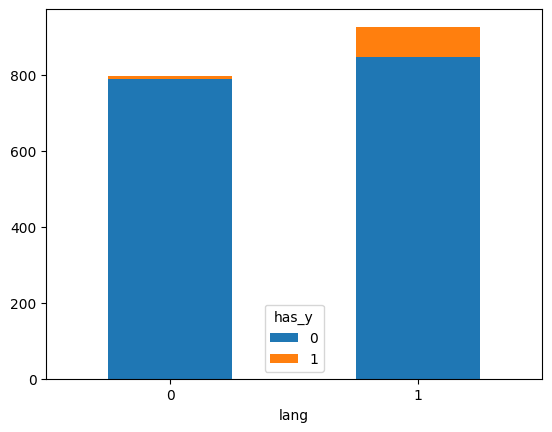

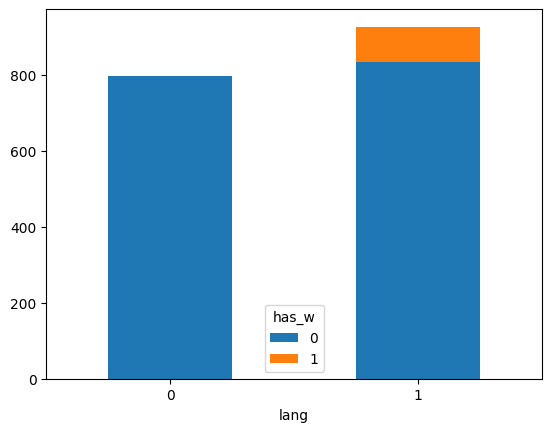

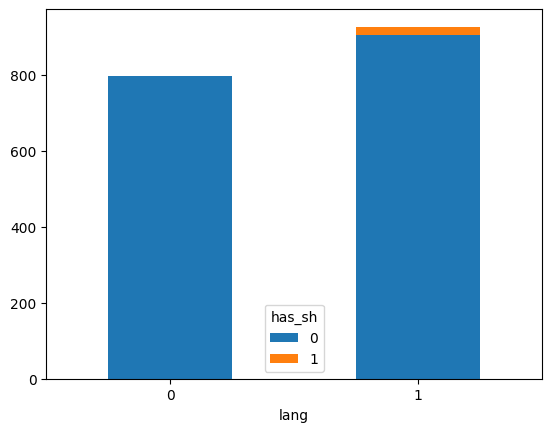

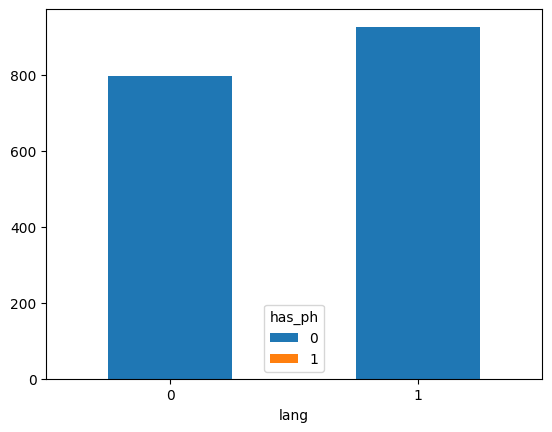

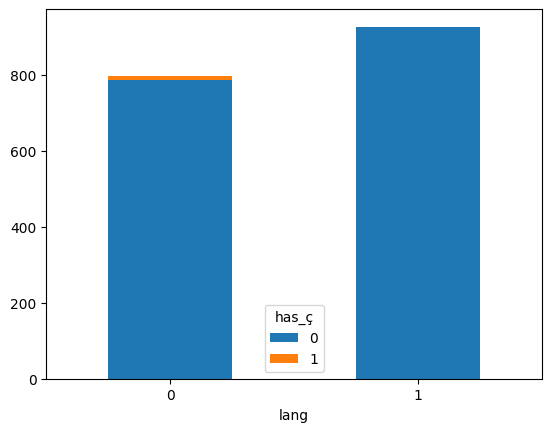

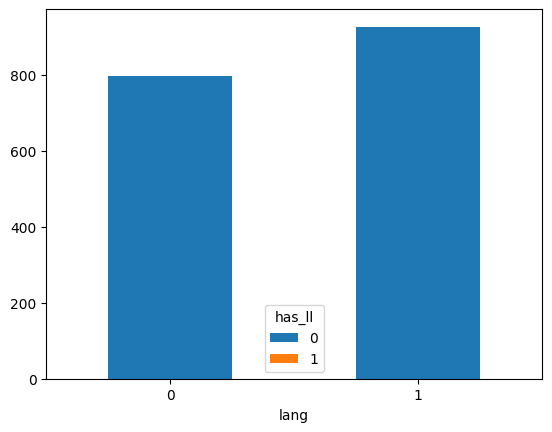

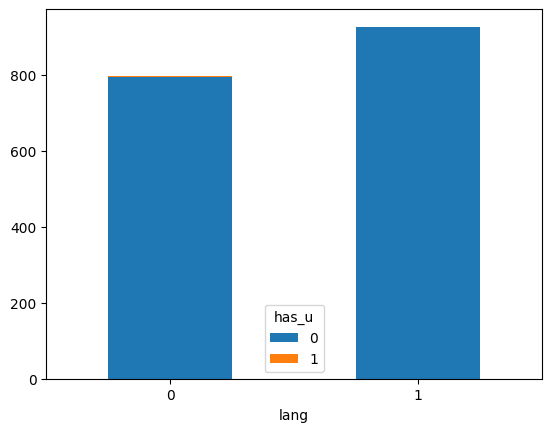

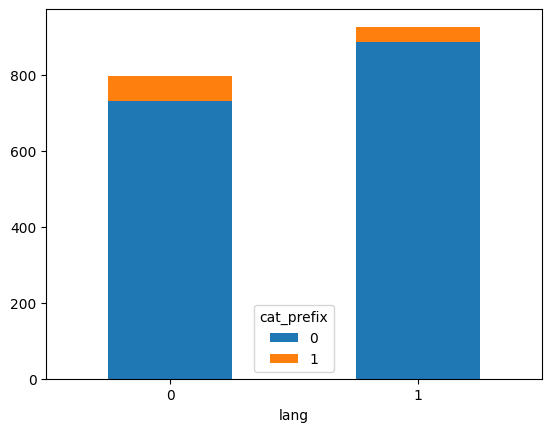

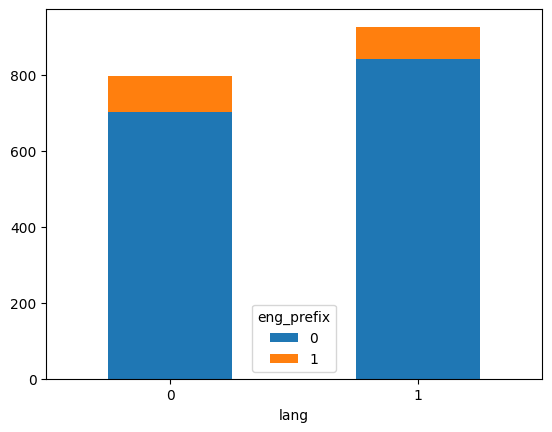

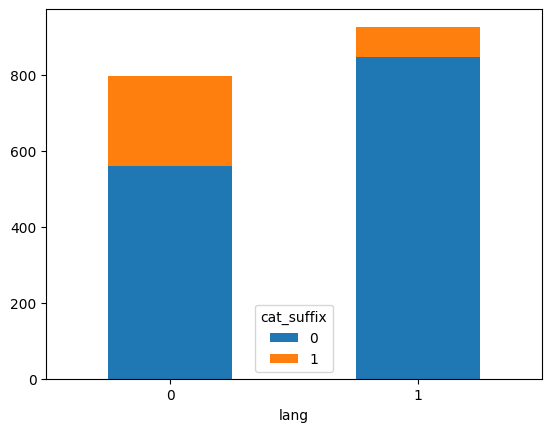

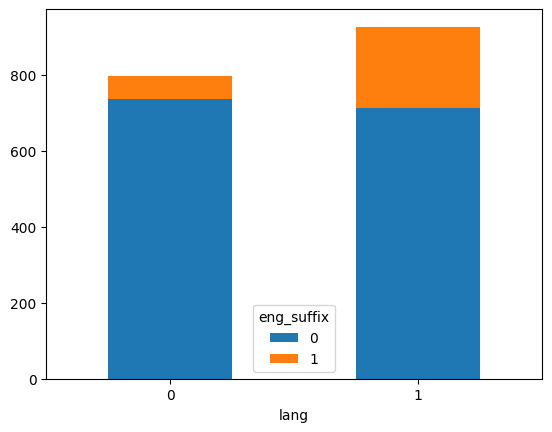

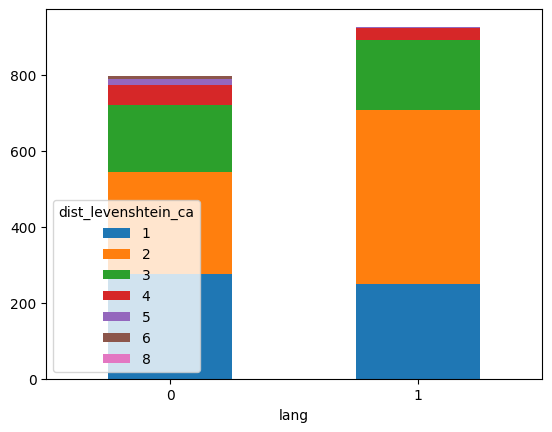

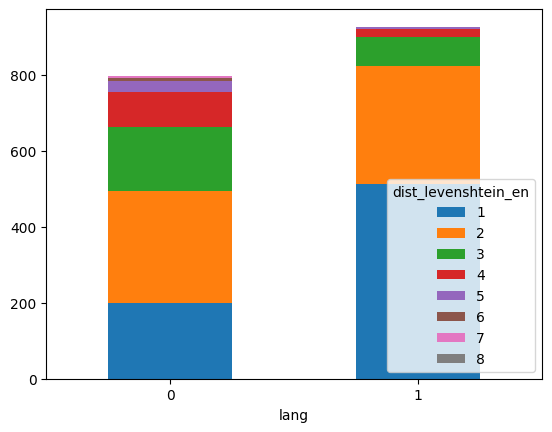

In [150]:
for feature in features_columns:
	ct = pd.crosstab(df_1['lang'], df_1[feature])
	ct.plot.bar(stacked=True, rot=0)

## Classificació

### 1r Intent

              precision    recall  f1-score   support

           0       0.74      0.63      0.68       235
           1       0.73      0.82      0.77       282

    accuracy                           0.73       517
   macro avg       0.73      0.72      0.73       517
weighted avg       0.73      0.73      0.73       517



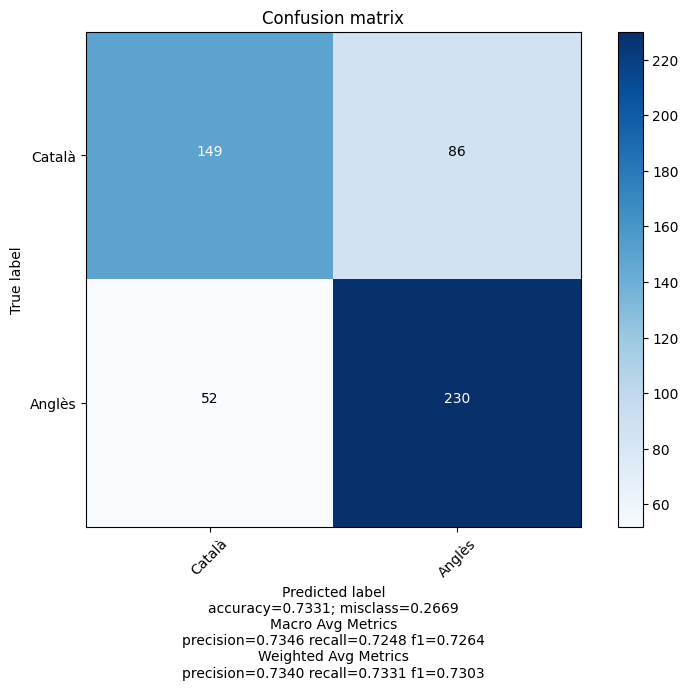

In [151]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame.copy(df_1)
y = df.pop('lang')
df.pop('paraula')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

svm = SVC(C=1000.0, kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, ['Català','Anglès'])


### 2n Intent (GridSearch)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly']
							} 

grid = GridSearchCV(SVC(), param_grid, refit = True)
grid.fit(X_train, y_train)

grid_predictions = grid.predict(X_test)

print(grid.best_params_)

print(classification_report(y_test, grid_predictions, target_names=['catala','angles']))

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

      catala       0.74      0.42      0.54       235
      angles       0.64      0.88      0.74       282

    accuracy                           0.67       517
   macro avg       0.69      0.65      0.64       517
weighted avg       0.69      0.67      0.65       517

